## Code to analyze FS output

1. DKT CT distributions 
2. ASEG vol distribution
3. Surface plots

In [7]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


In [8]:
current_release = "Apr_2023"
data_dir = f"/home/nikhil/projects/Parkinsons/qpn/"
session = "ses-01"
tabular_dir = f"{data_dir}/releases/{current_release}/tabular/"

# Current mr_proc manifest
mr_proc_manifest_csv = f"{tabular_dir}/mr_proc_manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# imaging derivatives
FS_dir = f"{data_dir}/derivatives/freesurfer/v6.0.1/"
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"
FS_DKT_dir = f"{FS_dir}/freesurfer-agg/{session}/"
DKT_csv = f"{FS_DKT_dir}/DKTatlas_average_thickness.csv"
ASEG_csv = f"{FS_DKT_dir}/aseg_subcortical_volumes.csv"


# UKB encoding of FS fields (DKT + asg)
region_field_dir = "/home/nikhil/projects/Parkinsons/region_field_ids/"
ukbb_dkt_ct_fields = f"{region_field_dir}/UKBB_DKT_CT_Fields.csv"
ukbb_aseg_vol_fields = f"{region_field_dir}/UKBB_ASEG_vol_Fields.csv"

# save dirs
results_dir = "../agg_dfs/"
figs_dir = "../figs/"


### Colormaps

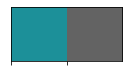

In [3]:
from enum import Enum
class my_colors(Enum):
    CONTROL = "#636363"
    PD = "#1c9099"
    
color_list = [my_colors.PD.value, my_colors.CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### mr_proc_manifest

In [4]:
manifest_cols = ["participant_id", "visit", "session", "bids_id"]
mr_proc_df = pd.read_csv(mr_proc_manifest_csv)
mr_proc_df = mr_proc_df[manifest_cols] 
mr_proc_participants = mr_proc_df["participant_id"].unique()
n_mr_proc_participants = len(mr_proc_participants)
print(f"mr_proc participants: {n_mr_proc_participants}")
mr_proc_df.head()

mr_proc participants: 208


,participant_id,visit,session,bids_id
0,MNI0056,V01,ses-01,sub-MNI0056
1,MNI0058,V01,ses-01,sub-MNI0058
2,MNI0068,V01,ses-01,sub-MNI0068
3,MNI0079,V01,ses-01,sub-MNI0079
4,MNI0103,V01,ses-01,sub-MNI0103


### Demographic data

In [5]:
demographics_df = pd.read_csv(demographics_csv)
participants = demographics_df["participant_id"].unique()
n_participants = len(participants)
print(f"n_participants: {n_participants}")

# replace column values
demographics_df["group"] = demographics_df["group"].replace({"CTRL": "control"})

group_counts = demographics_df.groupby(["group"]).count()
print(f"group counts: {group_counts}")
demographics_df.head()

n_participants: 208
group counts:          participant_id  visit  session  age  sex  dob  date_of_visit
group                                                                
PD                  166    166      166  166  166  166            166
control              40     40       40   39   40   39             40


,participant_id,visit,session,age,sex,dob,group,date_of_visit
0,MNI0056,V01,ses-01,79.2,M,1942-05-21,PD,2021-08-18
1,MNI0058,V01,ses-01,57.4,M,1964-03-14,PD,2021-08-18
2,MNI0068,V01,ses-01,69.1,M,1952-08-05,PD,2021-08-27
3,MNI0079,V01,ses-01,50.1,F,1971-11-25,PD,2021-12-22
4,MNI0103,V01,ses-01,82.0,M,1939-08-17,PD,2021-08-11


### Merge demographics and mr_proc manifest

In [6]:
demographics_df = pd.merge(demographics_df, mr_proc_df, on=["participant_id", "visit", "session"])
demographics_df.head()

,participant_id,visit,session,age,sex,dob,group,date_of_visit,bids_id
0,MNI0056,V01,ses-01,79.2,M,1942-05-21,PD,2021-08-18,sub-MNI0056
1,MNI0058,V01,ses-01,57.4,M,1964-03-14,PD,2021-08-18,sub-MNI0058
2,MNI0068,V01,ses-01,69.1,M,1952-08-05,PD,2021-08-27,sub-MNI0068
3,MNI0079,V01,ses-01,50.1,F,1971-11-25,PD,2021-12-22,sub-MNI0079
4,MNI0103,V01,ses-01,82.0,M,1939-08-17,PD,2021-08-11,sub-MNI0103


### UKB - DKT - ASEG fields and names

In [7]:
### DKT metadata
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_df["hemi_roi"] = DKT_fields_df["hemi"] + "_" + DKT_fields_df["roi"]

DKT_field_roi_dict = dict(zip(DKT_fields_df["Field ID"].values.astype("str"),DKT_fields_df["hemi_roi"].values))

lh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="lh"]["Field ID"].values.astype("str"))
rh_DKT_fields = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["Field ID"].values.astype("str"))
rois = list(DKT_fields_df[DKT_fields_df["hemi"]=="rh"]["roi"])

# hemi specific dict
lh_DKT_field_roi_dict = dict(zip(lh_DKT_fields,rois))
rh_DKT_field_roi_dict = dict(zip(rh_DKT_fields,rois))


### ASEG metadata
ASEG_fields_df = pd.read_csv(ukbb_aseg_vol_fields)

ASEG_fields_sorted = list(ASEG_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

lh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["Field ID"].values.astype("str"))
rh_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Right-"]["Field ID"].values.astype("str"))
global_ASEG_fields = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["Field ID"].values.astype("str"))
hemi_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"]=="Left-"]["roi"])
global_rois = list(ASEG_fields_df[ASEG_fields_df["hemi"].isna()]["roi"])

# hemi specific dict
lh_ASEG_field_roi_dict = dict(zip(lh_ASEG_fields,hemi_rois))
rh_ASEG_field_roi_dict = dict(zip(rh_ASEG_fields,hemi_rois))
global_ASEG_field_roi_dict = dict(zip(global_ASEG_fields,global_rois))
ASEG_fields_df.head()

,Unnamed: 0,Field ID,Description,metric,roi,hemi,hemi_ROI
0,43,26523,Volume of 3rd-Ventricle (whole brain),Volume,3rd-Ventricle,NaN,3rd-Ventricle
1,44,26524,Volume of 4th-Ventricle (whole brain),Volume,4th-Ventricle,NaN,4th-Ventricle
2,45,26525,Volume of 5th-Ventricle (whole brain),Volume,5th-Ventricle,NaN,5th-Ventricle
3,46,26564,Volume of Accumbens-area (left hemisphere),Volume,Accumbens-area,Left-,Left-Accumbens-area
4,47,26595,Volume of Accumbens-area (right hemisphere),Volume,Accumbens-area,Right-,Right-Accumbens-area


### Read DKT data

In [8]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df.head()

,Unnamed: 0,subject_id,27174,27175,27176,27177,27178,27179,27180,27181,...,27288,27289,27290,27291,27292,27293,27294,27295,27296,27297
0,0,sub-PD01709,2.625,2.271,1.832,3.288,2.520,2.237,2.489,2.169,...,2.423,2.244,2.831,2.233,2.360,2.103,2.700,2.412,2.563,2.786
1,1,sub-PD00215,2.530,2.505,1.986,3.076,2.559,2.238,2.645,2.389,...,2.625,2.420,2.635,2.323,2.530,2.169,2.933,2.511,2.529,3.031
2,2,sub-PD01295,2.282,2.432,1.869,2.933,2.584,2.313,2.631,2.090,...,2.208,2.290,2.169,2.033,2.367,2.196,2.593,2.310,2.156,2.640
3,3,sub-PD01398,2.574,2.536,2.050,3.246,2.580,2.165,2.427,2.356,...,2.693,2.347,2.468,2.065,2.466,2.197,2.704,2.429,2.696,2.754
4,4,sub-PD00849,2.297,2.468,2.006,3.240,2.703,2.257,2.591,2.534,...,2.544,2.454,2.671,2.324,2.576,2.264,2.761,2.546,2.681,2.827


In [9]:
CT_DKT_df = pd.read_csv(DKT_csv)
CT_DKT_df = CT_DKT_df.drop(columns=["Unnamed: 0"])
CT_DKT_df = CT_DKT_df.rename(columns={"subject_id":"bids_id"})

bids_ids = list(CT_DKT_df["bids_id"])
print(f"n_bids: {len(bids_ids)}")

CT_DKT_df = pd.merge(CT_DKT_df,demographics_df,on="bids_id",how="left")
CT_DKT_df.head()

CT_DKT_df.head()

n_bids: 201


,bids_id,27174,27175,27176,27177,27178,27179,27180,27181,27182,...,27296,27297,participant_id,visit,session,age,sex,dob,group,date_of_visit
0,sub-PD01709,2.625,2.271,1.832,3.288,2.520,2.237,2.489,2.169,1.902,...,2.563,2.786,PD01709,V01,ses-01,69.3,F,1951-12-06,PD,2021-03-30
1,sub-PD00215,2.530,2.505,1.986,3.076,2.559,2.238,2.645,2.389,2.070,...,2.529,3.031,PD00215,V01,ses-01,48.5,M,1971-05-22,PD,2019-11-19
2,sub-PD01295,2.282,2.432,1.869,2.933,2.584,2.313,2.631,2.090,2.167,...,2.156,2.640,PD01295,V01,ses-01,74.8,M,1944-06-11,PD,2019-04-06
3,sub-PD01398,2.574,2.536,2.050,3.246,2.580,2.165,2.427,2.356,2.243,...,2.696,2.754,PD01398,V01,ses-01,61.9,F,1958-04-09,PD,2020-02-28
4,sub-PD00849,2.297,2.468,2.006,3.240,2.703,2.257,2.591,2.534,2.267,...,2.681,2.827,PD00849,V01,ses-01,62.2,F,1956-05-10,PD,2018-07-31


### Filter demographics based on available BIDS data

In [10]:
demographics_df = demographics_df[demographics_df["bids_id"].isin(bids_ids)]
demographics_df.groupby(["group"])["age"].std()

group
PD          9.234079
control    11.412006
Name: age, dtype: float64

### Split DKT data into left and right hemisphere

In [11]:
save_results = False
demo_cols = ["participant_id","bids_id","age","sex","group"]

lh_CT_DKT_df = CT_DKT_df[lh_DKT_fields + demo_cols].copy()
lh_CT_DKT_df["hemi"] = "lh"
rh_CT_DKT_df = CT_DKT_df[rh_DKT_fields + demo_cols].copy()
rh_CT_DKT_df["hemi"] = "rh"

lh_CT_DKT_df = lh_CT_DKT_df.rename(columns=lh_DKT_field_roi_dict)
rh_CT_DKT_df = rh_CT_DKT_df.rename(columns=rh_DKT_field_roi_dict)

CT_DKT_df = pd.concat([lh_CT_DKT_df,rh_CT_DKT_df], axis=0)

if save_results:
    CT_DKT_df.to_csv(f"{results_dir}/CT_DKT_df.csv")
    
CT_DKT_df.head()

,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,superiorparietal,superiortemporal,supramarginal,transversetemporal,participant_id,bids_id,age,sex,group,hemi
0,2.625,2.271,1.832,3.288,2.520,2.237,2.489,2.994,2.169,1.902,...,1.974,2.610,2.288,2.320,PD01709,sub-PD01709,69.3,F,PD,lh
1,2.530,2.505,1.986,3.076,2.559,2.238,2.645,2.801,2.389,2.070,...,2.147,2.920,2.399,2.554,PD00215,sub-PD00215,48.5,M,PD,lh
2,2.282,2.432,1.869,2.933,2.584,2.313,2.631,2.742,2.090,2.167,...,2.251,2.677,2.428,2.157,PD01295,sub-PD01295,74.8,M,PD,lh
3,2.574,2.536,2.050,3.246,2.580,2.165,2.427,2.783,2.356,2.243,...,2.204,2.747,2.432,2.674,PD01398,sub-PD01398,61.9,F,PD,lh
4,2.297,2.468,2.006,3.240,2.703,2.257,2.591,2.948,2.534,2.267,...,2.209,2.789,2.418,2.628,PD00849,sub-PD00849,62.2,F,PD,lh


### Plot DKT

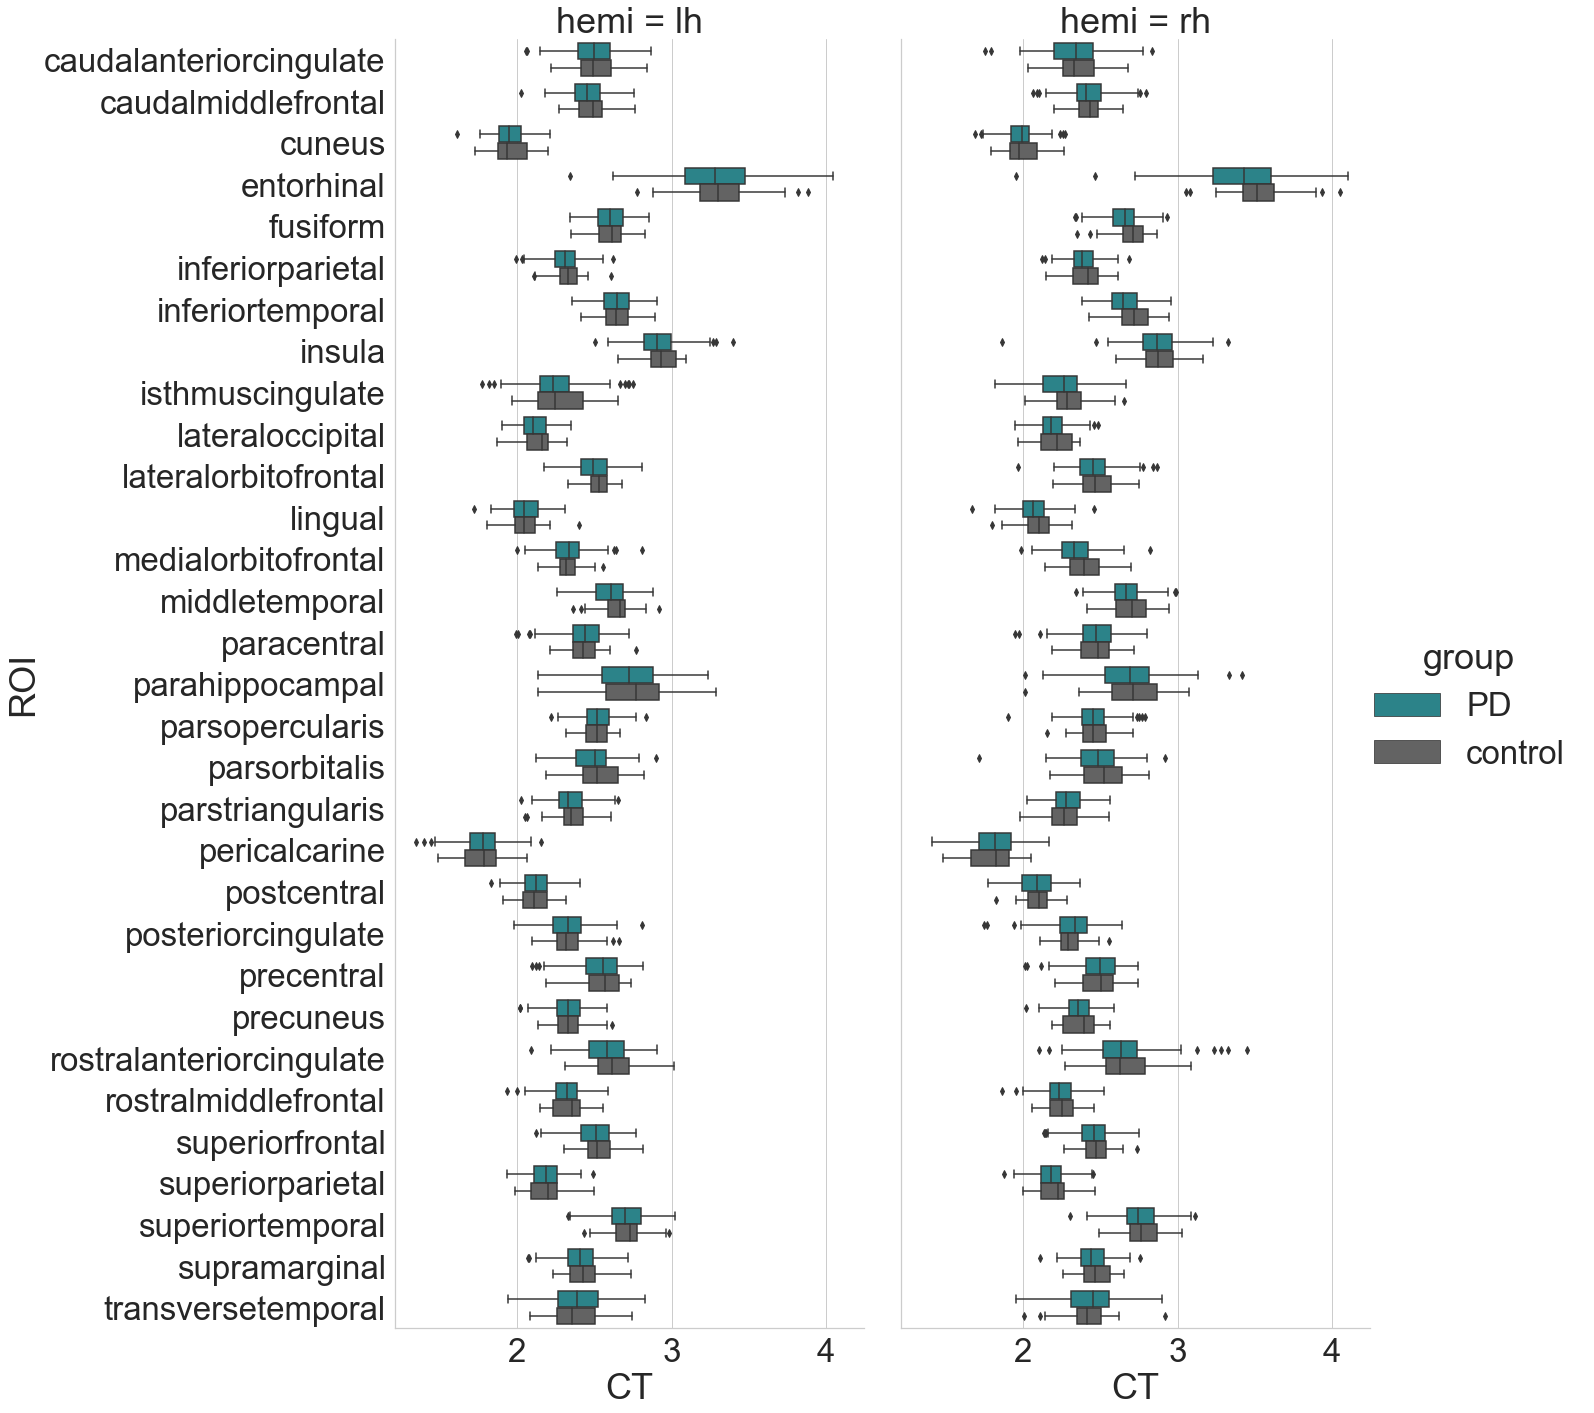

In [12]:
save_fig = False

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="group", col="hemi",kind="box",palette=palette, data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Volumetric measures

In [13]:
vol_ASEG_df = pd.read_csv(ASEG_csv)
vol_ASEG_df = vol_ASEG_df.drop(columns=["Unnamed: 0"])
vol_ASEG_df = vol_ASEG_df.rename(columns={"subject_id":"bids_id"})

bids_ids = list(vol_ASEG_df["bids_id"])
print(f"n_bids: {len(bids_ids)}")

# Subset fields because UKB has more fields than freesurfer enlists
lh_ASEG_fields = list(set(lh_ASEG_fields) & set(vol_ASEG_df.columns))
rh_ASEG_fields = list(set(rh_ASEG_fields) & set(vol_ASEG_df.columns))
global_ASEG_fields = list(set(global_ASEG_fields) & set(vol_ASEG_df.columns))

# Merge with demographics info
vol_ASEG_df = pd.merge(vol_ASEG_df,demographics_df,on="bids_id",how="left")

vol_ASEG_df.head()

n_bids: 201


,bids_id,26523,26524,26525,26564,26595,26563,26594,26526,26514,...,26566,26597,participant_id,visit,session,age,sex,dob,group,date_of_visit
0,sub-PD01709,1581.400024,1549.000000,0.0,347.299988,384.100006,965.200012,973.000000,20063.699219,939504.0,...,119.099998,161.800003,PD01709,V01,ses-01,69.3,F,1951-12-06,PD,2021-03-30
1,sub-PD00215,1887.400024,2606.399902,0.0,656.299988,593.099976,1789.500000,2258.000000,26626.500000,1457215.0,...,47.099998,20.799999,PD00215,V01,ses-01,48.5,M,1971-05-22,PD,2019-11-19
2,sub-PD01295,2653.300049,3345.699951,0.0,307.799988,424.899994,1500.599976,1678.900024,24461.099609,1321813.0,...,17.900000,19.700001,PD01295,V01,ses-01,74.8,M,1944-06-11,PD,2019-04-06
3,sub-PD01398,1175.000000,1684.199951,0.0,458.500000,488.700012,1384.800049,1771.099976,21090.699219,1114040.0,...,55.299999,17.000000,PD01398,V01,ses-01,61.9,F,1958-04-09,PD,2020-02-28
4,sub-PD00849,1069.199951,1408.300049,0.0,410.100006,387.299988,1394.500000,1472.199951,15741.799805,861734.0,...,60.900002,304.000000,PD00849,V01,ses-01,62.2,F,1956-05-10,PD,2018-07-31


### Split DKT data into left and right hemisphere

In [14]:
save_results = False

lh_vol_ASEG_df = vol_ASEG_df[lh_ASEG_fields + demo_cols].copy()
lh_vol_ASEG_df["hemi"] = "lh"
rh_vol_ASEG_df = vol_ASEG_df[rh_ASEG_fields + demo_cols].copy()
rh_vol_ASEG_df["hemi"] = "rh"
global_vol_ASEG_df = vol_ASEG_df[global_ASEG_fields + demo_cols].copy()
global_vol_ASEG_df["hemi"] = "global"

lh_vol_ASEG_df = lh_vol_ASEG_df.rename(columns=lh_ASEG_field_roi_dict)
rh_vol_ASEG_df = rh_vol_ASEG_df.rename(columns=rh_ASEG_field_roi_dict)
global_vol_ASEG_df = global_vol_ASEG_df.rename(columns=global_ASEG_field_roi_dict)

bilateral_vol_ASEG_df = pd.concat([lh_vol_ASEG_df,rh_vol_ASEG_df], axis=0)

if save_results:
    bilateral_vol_ASEG_df.to_csv(f"{results_dir}/bilateral_vol_ASEG_df.csv")
    global_vol_ASEG_df.to_csv(f"{results_dir}/global_vol_ASEG_df.csv")

bilateral_vol_ASEG_df.head()

,Inf-Lat-Vent,Lateral-Ventricle,Thalamus-Proper,Accumbens-area,Putamen,Cerebellum-White-Matter,Caudate,Pallidum,choroid-plexus,Cerebellum-Cortex,vessel,VentralDC,Amygdala,Hippocampus,participant_id,bids_id,age,sex,group,hemi
0,489.500000,9352.299805,5669.000000,347.299988,4249.799805,12525.599609,3174.300049,1908.800049,653.200012,46698.500000,119.099998,3524.500000,965.200012,2997.100098,PD01709,sub-PD01709,69.3,F,PD,lh
1,401.200012,12590.500000,8682.299805,656.299988,6260.799805,18601.199219,4036.899902,2450.500000,882.799988,67068.203125,47.099998,5495.100098,1789.500000,5238.200195,PD00215,sub-PD00215,48.5,M,PD,lh
2,2203.399902,68316.500000,8083.600098,307.799988,4465.100098,18328.000000,4826.000000,2174.600098,1167.599976,55459.101562,17.900000,4116.700195,1500.599976,3299.000000,PD01295,sub-PD01295,74.8,M,PD,lh
3,434.000000,16098.500000,6599.600098,458.500000,4216.399902,13749.400391,3759.199951,2168.300049,683.400024,40535.699219,55.299999,3989.600098,1384.800049,3575.899902,PD01398,sub-PD01398,61.9,F,PD,lh
4,503.700012,7524.899902,5532.500000,410.100006,3886.600098,9319.500000,2643.800049,1588.199951,234.800003,41938.800781,60.900002,2956.600098,1394.500000,3136.300049,PD00849,sub-PD00849,62.2,F,PD,lh


### Plot ASEG
- hemi 
- global

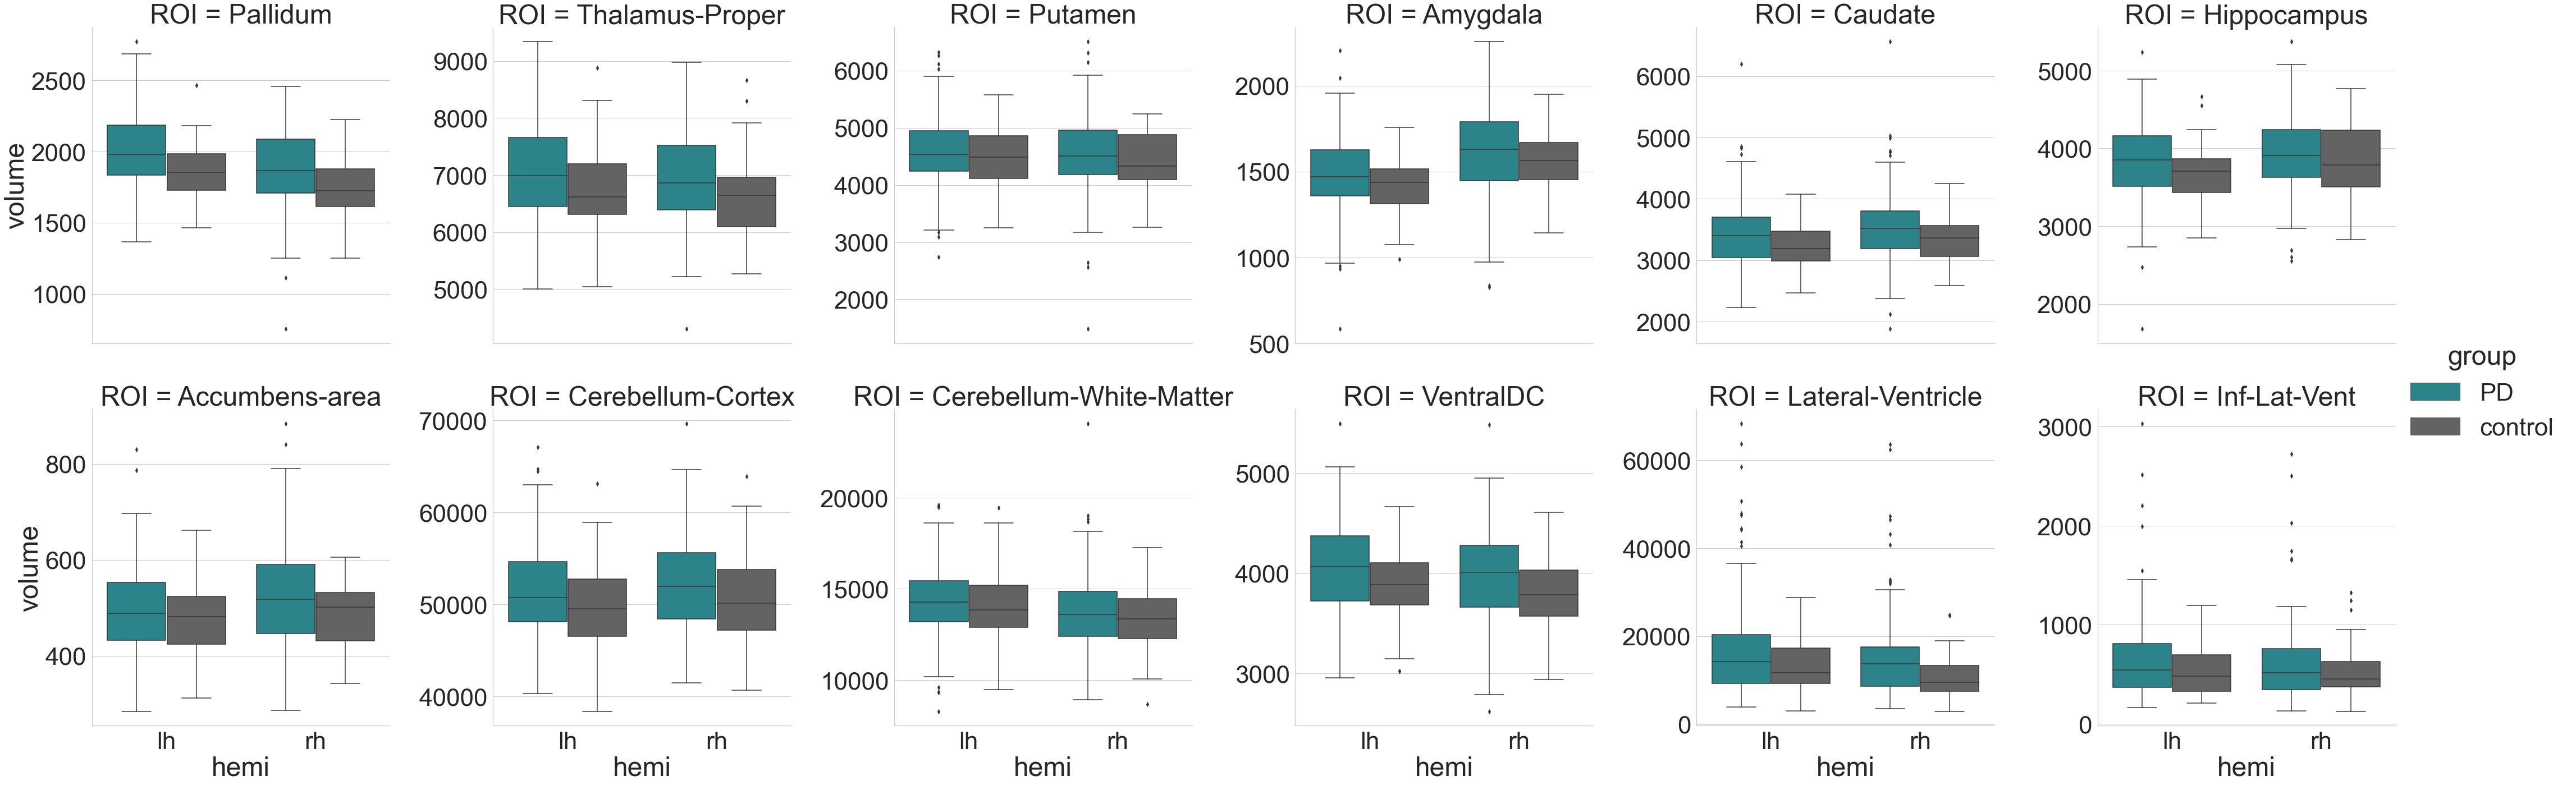

In [15]:
save_fig = False

vol_ASEG_df_melt = bilateral_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_bilateral.png")

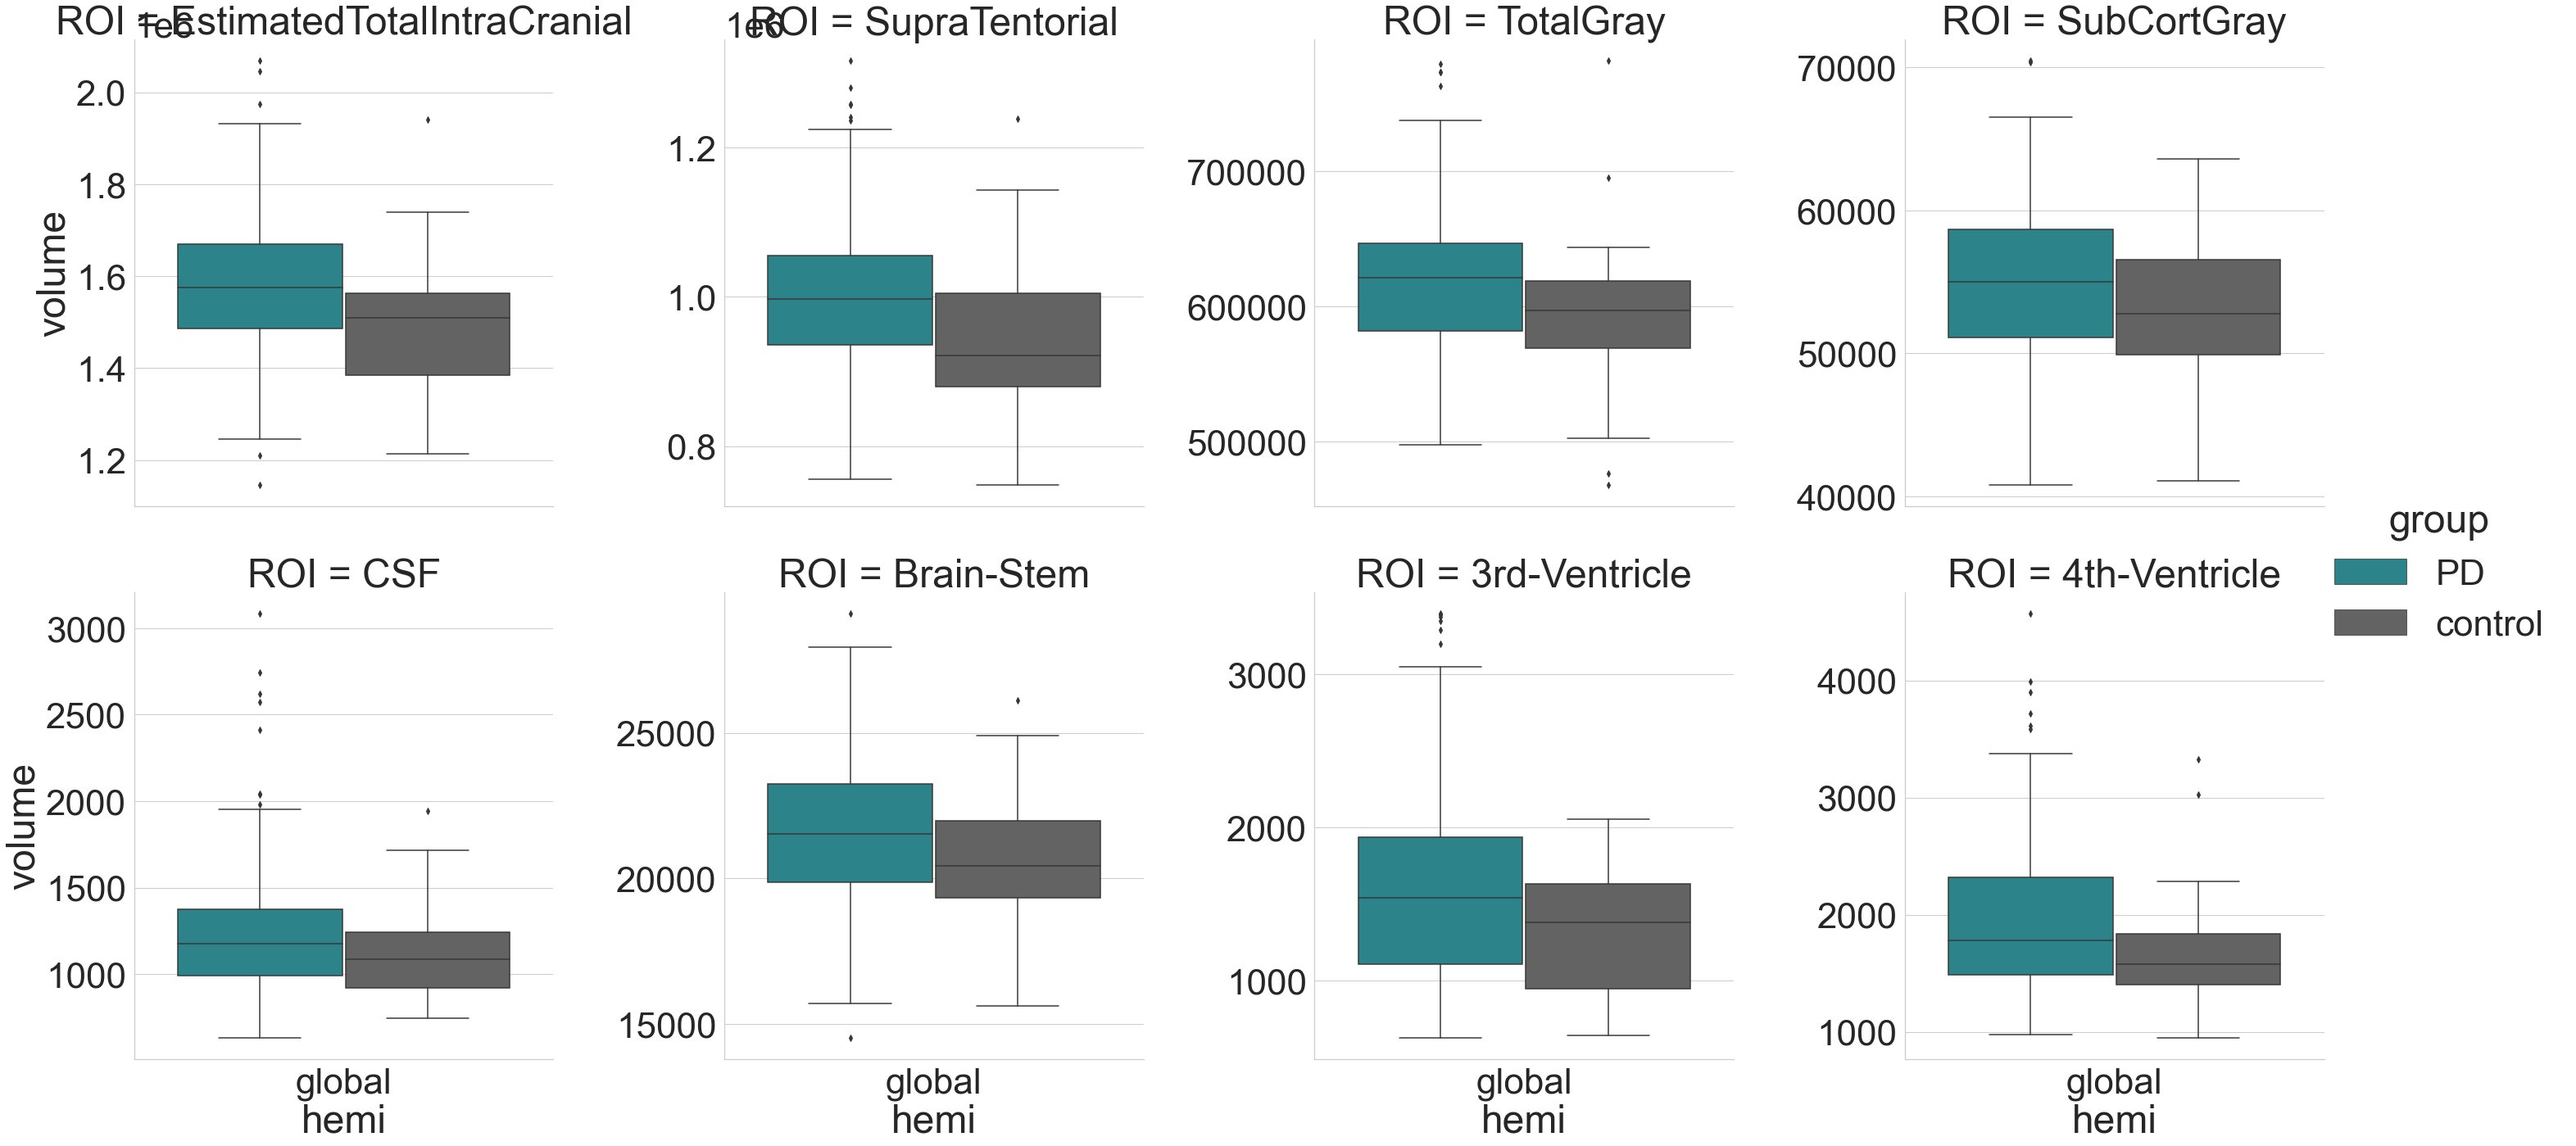

In [16]:
save_fig = False

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["EstimatedTotalIntraCranial", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="group", col="ROI",kind="box", col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Surface maps

In [3]:
fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
cmap = "Spectral" #"cubehelix"
view = "medial" #"lateral" #'medial'
sns.set(font_scale=2)

Downloaded 25108480 of 34242788 bytes (73.3%,    0.4s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/nikhil/nilearn_data/fsaverage/735bf0f211246c83396b5f21f706c224/download..... done.


In [10]:
fwhm_list = [10] #[0,5,10]
DX_groups = ["CTRL","PD"] 
hemi_list = ["lh", "rh"]
vmax = 4.3

for fwhm in fwhm_list:
    for i, group in enumerate(DX_groups):
        for j, hemi in enumerate(hemi_list):
            CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{group}_{fwhm}mm.mgh")
            avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))

            stat_map = avg_CT

            if hemi == "lh":
                hemisphere = "left"
            else:
                hemisphere = "right"

            bg_map=fsaverage[f"sulc_{hemisphere}"]
            fs_surf = fsaverage[f'pial_{hemisphere}']
            
            fig = plt.figure(figsize=(10, 6))
            fig_file = f"{figs_dir}/surf/{view}/{hemi}_surf_CT_{group}_{fwhm}mm.png"
            
            with sns.axes_style("white"):
                plotting.plot_surf_stat_map(
                    fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
                    colorbar=True, threshold=1, vmax=vmax, output_file=fig_file, cmap=cmap, figure=fig
            )

#bg_map=bg_map,vmax=4.5,

### CTRL - PD

In [27]:
fwhm = 10
cmap = "Spectral"
hemi_list = ["lh", "rh"]
vmax = 0.35 
threshold = 0.1 

for j, hemi in enumerate(hemi_list):
    CT_img_CTRL = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_CTRL_{fwhm}mm.mgh")
    avg_CT_CTRL = np.squeeze(np.mean(CT_img_CTRL.get_fdata(),axis=3))

    CT_img_PD = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_PD_{fwhm}mm.mgh")
    avg_CT_PD = np.squeeze(np.mean(CT_img_PD.get_fdata(),axis=3))

    stat_map = avg_CT_CTRL - avg_CT_PD

    if hemi == "lh":
        hemisphere = "left"
    else:
        hemisphere = "right"

    bg_map=fsaverage[f"sulc_{hemisphere}"]
    fs_surf = fsaverage[f'pial_{hemisphere}']
    
    fig = plt.figure(figsize=(10, 6))
    fig_file = f"{figs_dir}/surf/{view}/{hemi}_surf_CT_diff_{fwhm}mm.png"
    
    with sns.axes_style("white"):
        plotting.plot_surf_stat_map(
            fs_surf, stat_map, hemi=hemisphere, view=view,  title=f'{hemi} hemisphere', bg_map=bg_map,
            colorbar=True, threshold=threshold, vmax=vmax, output_file=fig_file, cmap=cmap, figure=fig
        )

### Brainspace test (plotter)

In [18]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from nibabel.freesurfer.mghformat import load
import nibabel as nib
from nilearn import datasets, surface, plotting

### Surface and annotation files

- Possible surfaces: ["fsaverage", "fsaverage5"]
- Possible annot: 
    - "fsaverage": ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]
    - "fsaverage5": ["schaefer-500"]

In [55]:
template_surface = "fsaverage" # "fsaverage" or "fsaverage5"
annot = "aparc"

if template_surface == "fsaverage":
    fsaverage_dir = "/home/nikhil/projects/Parkinsons/qpn/derivatives/freesurfer/v6.0.1/output/ses-01/fsaverage/"
    annot_dir = f"{fsaverage_dir}/label/"
    
else:
    fsaverage_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/surfaces/fsaverage5/"
    annot_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/parcellations/"

surf_dir = f"{fsaverage_dir}/surf/"

pial_lh = read_surface(f"{surf_dir}/lh.pial", itype='fs')
pial_rh = read_surface(f"{surf_dir}/rh.pial", itype='fs')


if annot in ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]:
    annot_lh= f"{annot_dir}/lh.{annot}.annot"
    annot_rh= f"{annot_dir}/rh.{annot}.annot"
else:
    annot_lh= f"{annot_dir}/lh.{annot}_mics.annot"
    annot_rh= f"{annot_dir}/rh.{annot}_mics.annot"

label = np.concatenate((nib.freesurfer.read_annot(annot_lh)[0], nib.freesurfer.read_annot(annot_rh)[0]), axis=0)

print(f"shape of concat array: {label.shape}")

shape of concat array: (327684,)


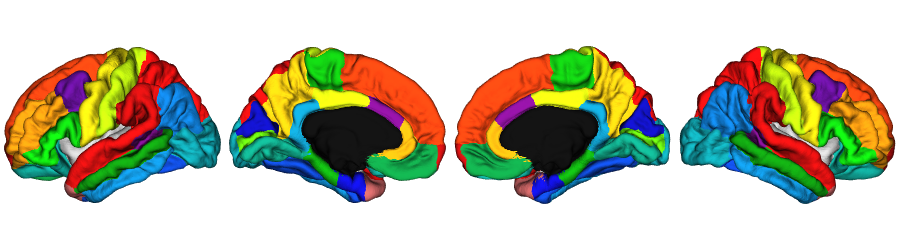

In [56]:
# plot labels on surface
plot_hemispheres(pial_lh, pial_rh, array_name=label, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='nipy_spectral', transparent_bg=False)

### Plot CT on surface

In [57]:
hemi_list = ["lh", "rh"]
group = "PD"
fwhm = 10
hemi_CT_list = []
for j, hemi in enumerate(hemi_list):
    CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{group}_{fwhm}mm.mgh")
    avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))
    hemi_CT_list.append(np.expand_dims(avg_CT,1))

th_fs5_10mm = np.squeeze(np.concatenate(hemi_CT_list, axis=0))
th_fs5_10mm.shape

(327684,)

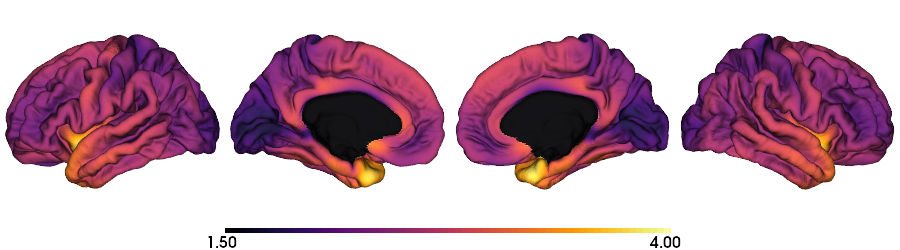

In [58]:
# Plot the surface
plot_hemispheres( fs5_lh, fs5_rh, array_name=th_fs5_10mm, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap="inferno", transparent_bg=True)